In [8]:
import scipy.io.wavfile
from scipy.fftpack import dct
from scipy.io import wavfile
from tqdm import tqdm
from python_speech_features import mfcc, logfbank
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


In [9]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Domain', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            # axes[x,y].get_xaxis().set_visible(False)
            # axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Frequency Domain (After Fourier Transforms)', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            # axes[x,y].get_xaxis().set_visible(False)
            # axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Spectrograms (Filter Bank Coefficients)', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            # axes[x,y].get_xaxis().set_visible(False)
            # axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Spectrograms (Mel Frequency Cepstrum Coefficients)', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def calc_fft(y, rate): # y is the signal
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate) # d = the amount of time that passes between 2 samples
    Y = abs(np.fft.rfft(y)/n) # magnitude # /n - normalize for the length of the signal ( not necesarily needed for this example since all recordings have the same length )
    return (Y, freq)

In [10]:
df = pd.read_csv('../statistics/instruments.csv')
df.set_index('fname', inplace=True)
display(df)

for f in df.index:
    rate, signal = wavfile.read('../wavfiles/instruments/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

display(df)

,label
fname,
5388d14d.wav,Saxophone
c685f05f.wav,Saxophone
36d20ab5.wav,Saxophone
d6665734.wav,Saxophone
7352e28f.wav,Saxophone
...,...
3c713bcf.wav,Clarinet
2fc00271.wav,Clarinet
b0c06255.wav,Clarinet


,label,length
fname,,
5388d14d.wav,Saxophone,4.14
c685f05f.wav,Saxophone,1.54
36d20ab5.wav,Saxophone,4.90
d6665734.wav,Saxophone,10.50
7352e28f.wav,Saxophone,6.24
...,...,...
3c713bcf.wav,Clarinet,6.14
2fc00271.wav,Clarinet,4.20
b0c06255.wav,Clarinet,4.08


label
Acoustic_guitar     6.948667
Bass_drum           1.937333
Cello               5.000667
Clarinet            6.596000
Double_bass         3.206000
Flute               8.054667
Hi-hat              3.357333
Saxophone           7.124000
Snare_drum          3.987333
Violin_or_fiddle    4.530000
Name: length, dtype: float64

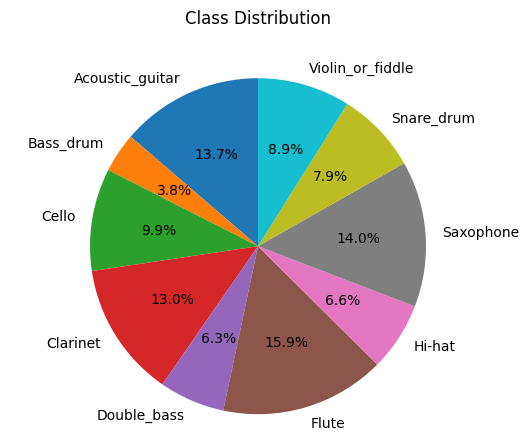

In [11]:
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()
display(class_dist)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')
plt.show()
df.reset_index(inplace=True)

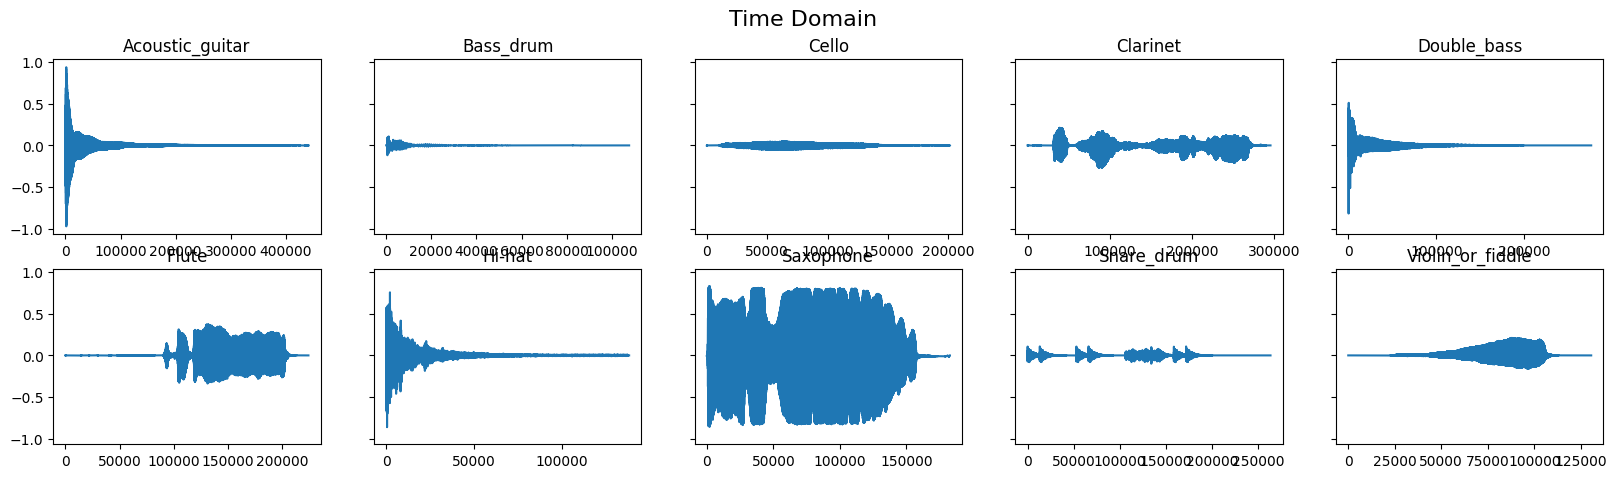

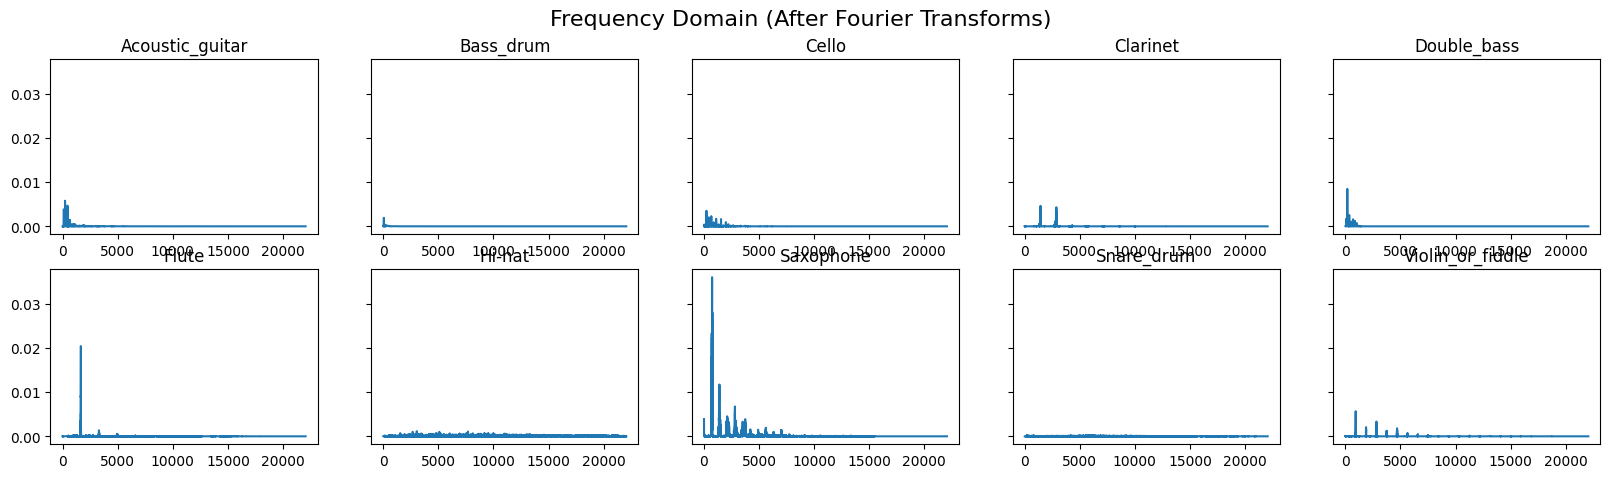

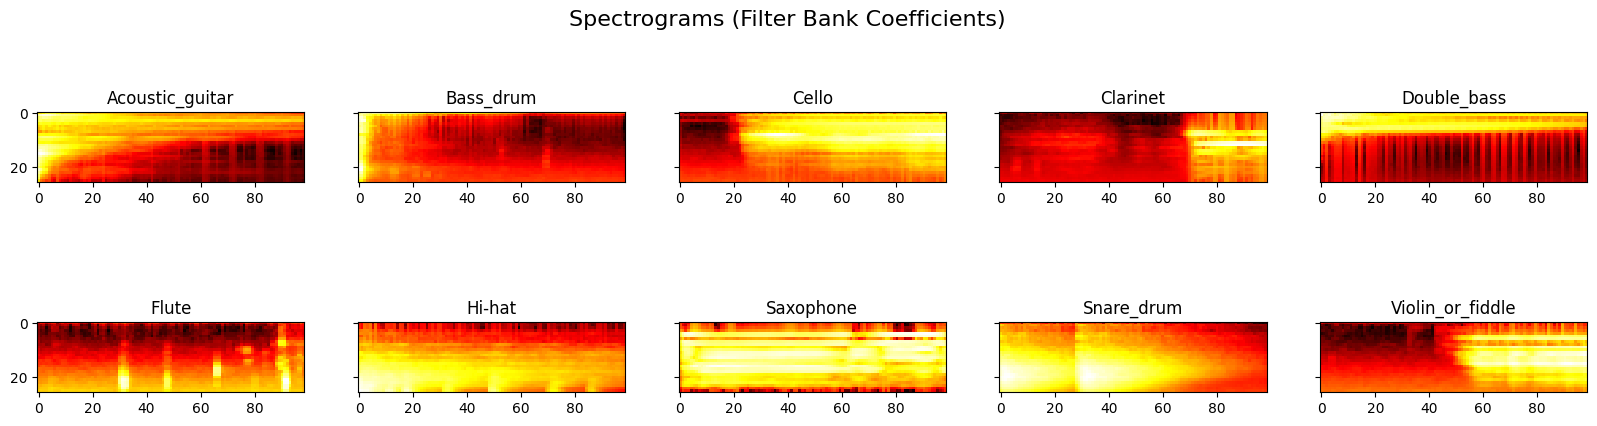

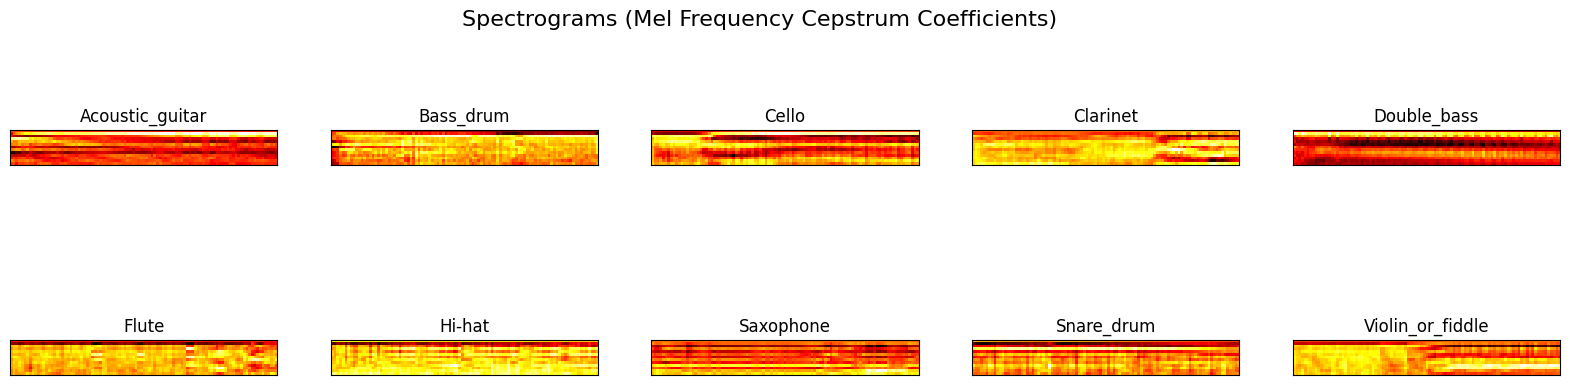

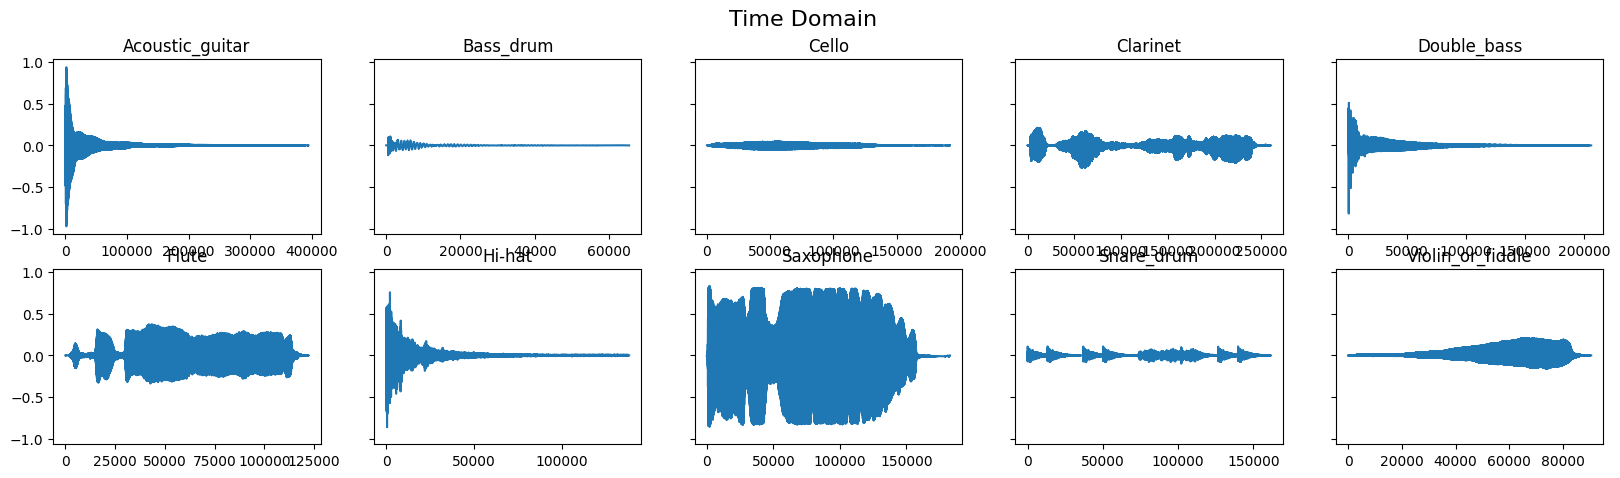

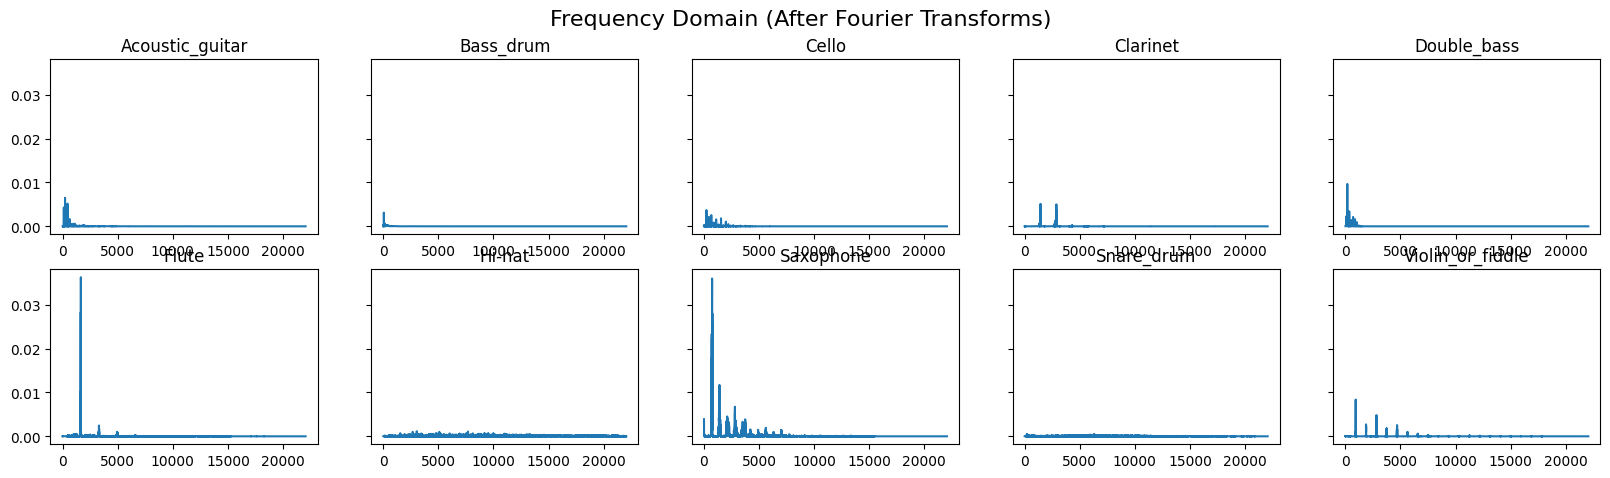

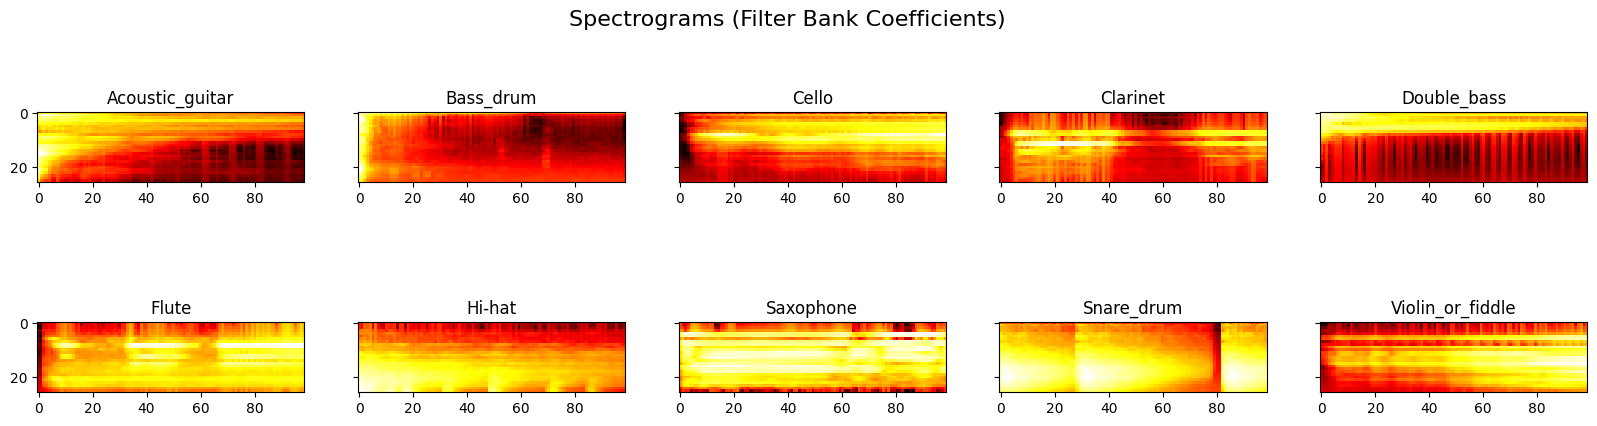

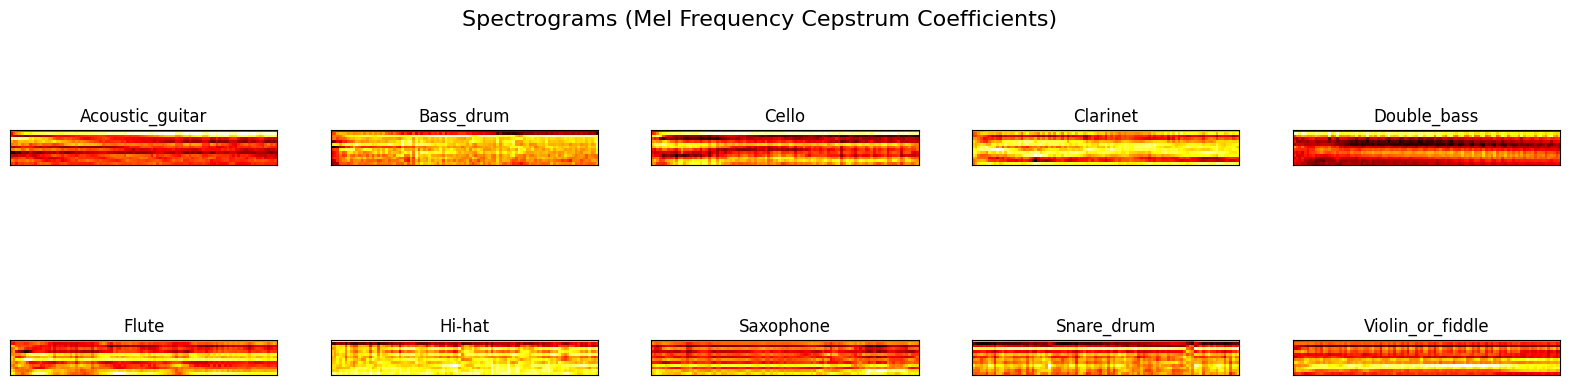

In [12]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

# ENVELOPING
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center = True).mean() # window_size = 1/10th of a second
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)

    return mask

# Without enveloping
for c in classes:
    wav_file = df[df.label == c].iloc[0, 0]
    signal, rate = librosa.load('wavfiles/instruments/'+wav_file, sr=44100)


    signals[c] = signal
    fft[c] = calc_fft(signal, rate)

    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T # PART 3 7:20
    fbank[c] = bank

    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T # typically half of filter banks for number of cepstrals
    mfccs[c] = mel

plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

# With noise floor & windowing / enveloping - basically eliminates areas where the amplitude is too low ( negligible ), where there is potential quiet
for c in classes:
    wav_file = df[df.label == c].iloc[0, 0]
    signal, rate = librosa.load('wavfiles/instruments/'+wav_file, sr=44100)

    # Noise floor detection of a signal
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]

    signals[c] = signal
    fft[c] = calc_fft(signal, rate)

    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T # PART 3 7:20
    fbank[c] = bank

    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T # typically half of filter banks for number of cepstrals
    mfccs[c] = mel

plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

In [13]:
# CLEANING / DOWN-SAMPLING TO 16000 beacuse we don't usually have frequencies that high
if len(os.listdir('clean')) == 0:
    for f in tqdm(df.fname):
        signal, rate = librosa.load('wavfiles/instruments/'+f, sr=16000)
        mask = envelope(signal, rate, 0.0005)
        wavfile.write(filename='clean/'+f, rate=rate, data=signal[mask])
